In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
from tab_transformer_pytorch import FTTransformer, TabTransformer
import sys
import time
from torch import Tensor
from typing import Literal

device_in_use='cpu'

In [2]:
# df_train = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/higgs/train.csv')
# df_test = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/higgs/test.csv')
# df_val = pd.read_csv('/home/cscadmin/CyberResearch/CAT-Transformer/datasets/higgs/validation.csv') #READ FROM RIGHT SPOT

# df_train = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\california\train.csv')
# df_test = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\california\test.csv')
# df_val = pd.read_csv(r'C:\Users\smbm2\projects\CAT-Transformer\datasets\california\validation.csv') #READ FROM RIGHT SPOT

df_train = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/california_sklearn/train.csv')
df_test = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/california_sklearn/test.csv')
df_val = pd.read_csv('/home/warin/projects/CAT-Transformer/datasets/california_sklearn/validation.csv')

In [3]:

cont_columns = [ 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude']
target = ['MedInc']

#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cont_columns + target
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print(target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cont_columns, 'MedInc')
val_dataset = SingleTaskDataset(df_val, cont_columns, 'MedInc')
test_dataset = SingleTaskDataset(df_test, cont_columns, 'MedInc')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

[9851]


In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class EmbeddingsRFFforIndividualFeatures(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont,  num_target_labels, rff_on, linear_on:bool):
        super(EmbeddingsRFFforIndividualFeatures, self).__init__()

        self.rff_on = rff_on

        self.linear_on = linear_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)

        embeddings = []
        if self.linear_on:
            x = torch.stack(rff_vectors, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = rff_vectors

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)


        return class_embeddings, context

class EmbeddingsRFFforAllFeatures(nn.Module):
    def __init__(self, sigma, embed_size, input_size, n_cont, num_target_labels, rff_on, linear_on:bool):
        super(EmbeddingsRFFforAllFeatures, self).__init__()

        self.rff_on = rff_on
        self.n_cont = n_cont
        self.linear_on=linear_on

        if self.rff_on:
            self.rff = GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) 
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        
        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i in range(self.n_cont):
                input = x[:,i,:]
                out = self.rff(input)
                rff_vectors.append(out)
        
        embeddings = []
        if self.linear_on:
            x = torch.stack(rff_vectors, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = rff_vectors

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context
    
class PeriodicActivation(nn.Module):
    def __init__(self, sigma, embed_size, n_cont, num_target_labels,trainable: bool, initialization: str, linear_on:bool):
        super(PeriodicActivation, self).__init__()

        self.n = embed_size
        self.sigma = sigma
        self.trainable = trainable
        self.initialization = initialization
        self.linear_on = linear_on
        self.n_cont = n_cont

        if self.initialization == 'log-linear':
            coefficients = self.sigma ** (torch.arange(self.n//2) / self.n) # sigma matters here but more in the way of >1 or <1
            coefficients = coefficients[None] #same as unsqueeze(0)
        else:
            assert self.initialization == 'normal'
            coefficients = torch.normal(0.0, self.sigma, (1, self.n//2))

        if self.trainable:
            self.coefficients = nn.Parameter(coefficients)
        else:
            self.register_buffer('coefficients', coefficients)

        if self.linear_on:
            self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=embed_size, out_features=embed_size) for _ in range(n_cont)])

        
        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)

        temp = []
        for i in range(self.n_cont):
            input = x[:,i,:]
            out = torch.cat([torch.cos(self.coefficients * input), torch.sin(self.coefficients * input)], dim=-1)
            temp.append(out)
        
        embeddings = []
        if self.linear_on:
            x = torch.stack(temp, dim=1)
            for i, e in enumerate(self.cont_embeddings):
                goin_in = x[:,i,:]
                goin_out = e(goin_in)
                embeddings.append(goin_out)
        else:
            embeddings = temp

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context


class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, 1)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class CATTransformer(nn.Module):
    def __init__(self, 
                 rff_on = True,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 n_cont = 0,
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8],
                embedding_scheme ="rff_unique",
                trainable=True,
                linear_on=True
                 ):
        super(CATTransformer, self).__init__()

        assert(embedding_scheme in ['rff_unique', 'rff', 'log-linear_periodic', 'normal_periodic']), "wrong embedding_scheme"

        if embedding_scheme == 'rff_unique':
            self.embeddings = EmbeddingsRFFforIndividualFeatures(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     n_cont=n_cont, num_target_labels=len(targets_classes), linear_on=linear_on)
        elif embedding_scheme == 'log-linear_periodic':
            self.embeddings = PeriodicActivation(sigma=sigma, embed_size=embed_size, n_cont=n_cont, 
                                                 num_target_labels=len(target_classes),trainable=trainable,initialization='log-linear', linear_on=linear_on)
        elif embedding_scheme == 'normal_periodic':
            self.embeddings = PeriodicActivation(sigma=sigma, embed_size=embed_size, n_cont=n_cont, 
                                                 num_target_labels=len(target_classes),trainable=trainable,initialization='normal',linear_on=linear_on)
        else:
            self.embeddings = EmbeddingsRFFforAllFeatures(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     n_cont=n_cont, num_target_labels=len(targets_classes),linear_on=linear_on)
            
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=x) for x in targets_classes])
        
    def forward(self, x):
        class_embed, context = self.embeddings(x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw
    
    # Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0
  
    total_loss = 0
    total_r2_score = 0
    root_mean_squared_error_total = 0

    for (features,labels_task1) in dataloader:
        features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)

        task_predictions = model(features) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions[0].squeeze(1), labels_task1)
        total_loss += loss.item()

        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions[0].squeeze(1))
        total_r2_score += r2

        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions[0].squeeze(1))
        root_mean_squared_error_total+=rmse_value

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_loss = 0
  total_r2_score = 0
  root_mean_squared_error_total = 0

  with torch.no_grad():
    for (features,labels_task1) in dataloader:
        features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)

        #compute prediction error
        task_predictions = model(features) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions[0].squeeze(1), labels_task1)
        total_loss += loss.item()

        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions[0].squeeze(1))
        total_r2_score += r2
        
        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions[0].squeeze(1))
        root_mean_squared_error_total+=rmse_value

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

def r2_score_manual(y_true, y_pred):
    # Calculate the mean of true labels
    y_mean = torch.mean(y_true)

    # Calculate the total sum of squares
    total_ss = torch.sum((y_true - y_mean)**2)

    # Calculate the residual sum of squares
    residual_ss = torch.sum((y_true - y_pred)**2)

    # Calculate R-squared
    r2 = 1 - (residual_ss / total_ss)

    return r2.item()  # Convert to a Python float

def rmse(y_true, y_pred):
    # Calculate the squared differences
    squared_diff = (y_true - y_pred)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff)

    # Calculate the square root to obtain RMSE
    rmse = torch.sqrt(mean_squared_diff)

    return rmse.item()  # Convert to a Python float

# Log-Linear RFF

$\sigma = -2$

Epoch [ 1/200]       | Train: Loss nan, Accuracy 0.36458                                 | Test: Loss nan, Accuracy 0.36319, F1 0.19353
Epoch [ 2/200]       | Train: Loss nan, Accuracy 0.36458                                 | Test: Loss nan, Accuracy 0.36319, F1 0.19353
Epoch [ 3/200]       | Train: Loss nan, Accuracy 0.36458                                 | Test: Loss nan, Accuracy 0.36319, F1 0.19353
Epoch [ 4/200]       | Train: Loss nan, Accuracy 0.36458                                 | Test: Loss nan, Accuracy 0.36319, F1 0.19353
Epoch [ 5/200]       | Train: Loss nan, Accuracy 0.36458                                 | Test: Loss nan, Accuracy 0.36319, F1 0.19353
Epoch [ 6/200]       | Train: Loss nan, Accuracy 0.36458                                 | Test: Loss nan, Accuracy 0.36319, F1 0.19353
Epoch [ 7/200]       | Train: Loss nan, Accuracy 0.36458                                 | Test: Loss nan, Accuracy 0.36319, F1 0.19353
Epoch [ 8/200]       | Train: Loss nan, Accuracy

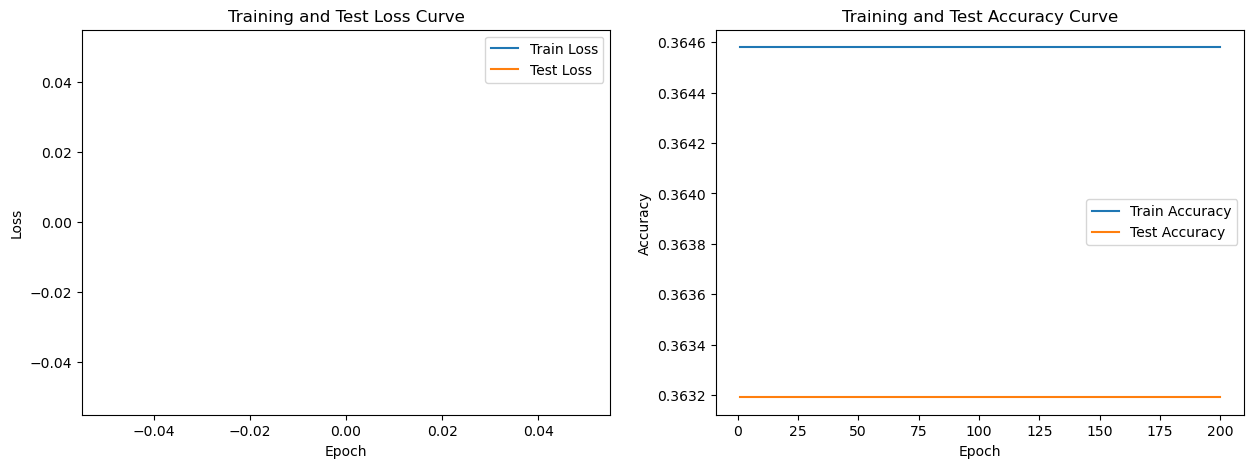

In [5]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=-2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                   
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
              
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 200 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

$\sigma = -1$

In [6]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=-1,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                   
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
              
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 200 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

Epoch [ 1/200]       | Train: Loss nan, Accuracy 0.36458                                 | Test: Loss nan, Accuracy 0.36319, F1 0.19353


KeyboardInterrupt: 

$\sigma = -0.5$

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=-0.5,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                   
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
              
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 200 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

$\sigma = 0.5$

Epoch [ 1/500]       | Train: Loss 4.61455, R2 -0.28788, RMSE 2.08795                    | Test: Loss 3.87617, R2 0.02866, RMSE 1.94974
Epoch [ 2/500]       | Train: Loss 2.50285, R2 0.30260, RMSE 1.55418                     | Test: Loss 1.20046, R2 0.66059, RMSE 1.08656
Epoch [ 3/500]       | Train: Loss 1.29807, R2 0.63898, RMSE 1.13357                     | Test: Loss 1.12699, R2 0.68919, RMSE 1.05453
Epoch [ 4/500]       | Train: Loss 1.20136, R2 0.66520, RMSE 1.09047                     | Test: Loss 1.07541, R2 0.71101, RMSE 1.02860
Epoch [ 5/500]       | Train: Loss 1.20332, R2 0.66753, RMSE 1.08969                     | Test: Loss 1.06065, R2 0.70308, RMSE 1.02009
Epoch [ 6/500]       | Train: Loss 1.13216, R2 0.68385, RMSE 1.06043                     | Test: Loss 1.07146, R2 0.66251, RMSE 1.02810
Epoch [ 7/500]       | Train: Loss 1.11113, R2 0.68861, RMSE 1.05000                     | Test: Loss 1.00103, R2 0.71917, RMSE 0.98900
Epoch [ 8/500]       | Train: Loss 1.07803, R2 0

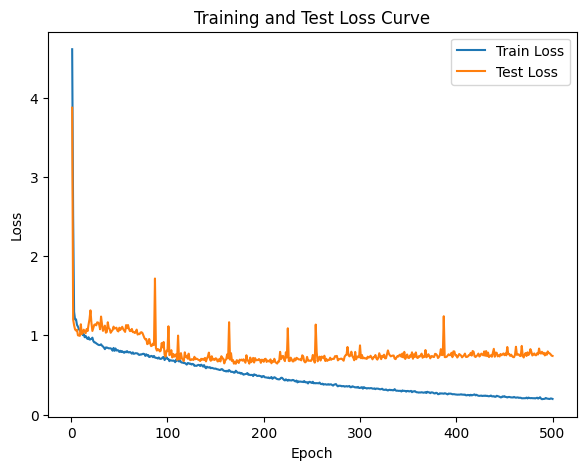

In [9]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.MSELoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1
        prediction = predictions
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=0.5,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                   
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
              
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 500 #Set the number of epochs

train_losses = []
train_rmse = [] 
test_losses = []
test_rmse = []  


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
    train_loss, r2_train, rmse_train = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
    test_loss, r2_test, rmse_test = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_rmse.append(rmse_train)
    # train_accuracies_2.append(train_accuracy_2)
    # train_recalls.append(train_recall) 
    # train_f1_scores.append(train_f1)
    test_losses.append(test_loss)
    test_rmse.append(rmse_test)
    # test_accuracies_2.append(test_accuracy_2)
    # test_recalls.append(test_recall)
    # test_f1_scores.append(test_f1)
    # Formatting for easier reading
    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {format_metric(train_loss)}, R2 {format_metric(r2_train)}, RMSE {format_metric(rmse_train)}"
    test_metrics = f"Test: Loss {format_metric(test_loss)}, R2 {format_metric(r2_test)}, RMSE {format_metric(rmse_test)}"
    print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

best_index = test_rmse.index(min(test_rmse))
print(f"Best rmse {test_rmse[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")

$\sigma = 1$

Epoch [ 1/500]       | Train: Loss 4.32444, R2 -0.23182, RMSE 2.04175                    | Test: Loss 3.34203, R2 0.05480, RMSE 1.81563
Epoch [ 2/500]       | Train: Loss 2.33227, R2 0.34701, RMSE 1.50658                     | Test: Loss 1.33807, R2 0.64581, RMSE 1.14950
Epoch [ 3/500]       | Train: Loss 1.33251, R2 0.62631, RMSE 1.14928                     | Test: Loss 1.12294, R2 0.68547, RMSE 1.05280
Epoch [ 4/500]       | Train: Loss 1.22394, R2 0.65923, RMSE 1.10138                     | Test: Loss 1.07679, R2 0.70798, RMSE 1.02962
Epoch [ 5/500]       | Train: Loss 1.14544, R2 0.67851, RMSE 1.06601                     | Test: Loss 1.03192, R2 0.71527, RMSE 1.01213
Epoch [ 6/500]       | Train: Loss 1.07980, R2 0.69739, RMSE 1.03470                     | Test: Loss 1.12300, R2 0.68964, RMSE 1.05343
Epoch [ 7/500]       | Train: Loss 1.07684, R2 0.69900, RMSE 1.03078                     | Test: Loss 1.05952, R2 0.71290, RMSE 1.01548
Epoch [ 8/500]       | Train: Loss 1.03933, R2 0

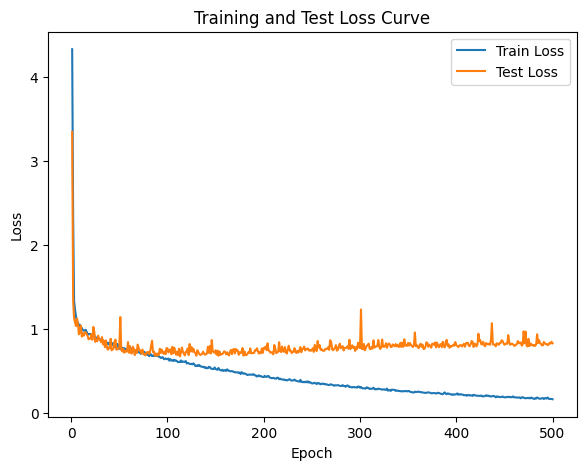

In [10]:
class LossFunction(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunction, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.MSELoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1
        prediction = predictions
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
model = CATTransformer(rff_on=True,
                       sigma=1,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                   
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
              
                       embedding_scheme='log-linear_periodic',
                       trainable=False,
                       linear_on=True).to(device_in_use)

def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = LossFunction(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 500 #Set the number of epochs

train_losses = []
train_rmse = [] 
test_losses = []
test_rmse = []  


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
    train_loss, r2_train, rmse_train = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
    test_loss, r2_test, rmse_test = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
    train_losses.append(train_loss)
    train_rmse.append(rmse_train)
    # train_accuracies_2.append(train_accuracy_2)
    # train_recalls.append(train_recall) 
    # train_f1_scores.append(train_f1)
    test_losses.append(test_loss)
    test_rmse.append(rmse_test)
    # test_accuracies_2.append(test_accuracy_2)
    # test_recalls.append(test_recall)
    # test_f1_scores.append(test_f1)
    # Formatting for easier reading
    epoch_str = f"Epoch [{t+1:2}/{epochs}]"
    train_metrics = f"Train: Loss {format_metric(train_loss)}, R2 {format_metric(r2_train)}, RMSE {format_metric(rmse_train)}"
    test_metrics = f"Test: Loss {format_metric(test_loss)}, R2 {format_metric(r2_test)}, RMSE {format_metric(rmse_test)}"
    print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

best_index = test_rmse.index(min(test_rmse))
print(f"Best rmse {test_rmse[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")